# Regression and classification using our AutoGrad library

First, we will import the latest version of our AutoGrad framework, as it resulted from the previous exercise

In [227]:
import numpy as np

In [228]:
def vAdd(A, B): # Addition
    A = _ensureVariable(A)
    B = _ensureVariable(B)
    result = Variable(A.value + B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    if A.requiresGrad:
        result.requiresGrad = True; # if any of the parent variables requires grad, the result should also require it
        def gradfn(route_val):
            return route_val # == route_val * 1, as here dresult / dA = 1
        result.gradRoutes.append((A, gradfn)) 
    if B.requiresGrad:
        result.requiresGrad = True; # if any of the parent variables requires grad, the result should also require it
        def gradfn(route_val):
            return route_val # == route_val * 1, as here dresult / dA = 1
        result.gradRoutes.append((B, gradfn))
    
    return result
    
def vMul(A, B): # Addition
    A = _ensureVariable(A)
    B = _ensureVariable(B)    
    result = Variable(A.value * B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    if A.requiresGrad:
        result.requiresGrad = True; # if any of the parent variables requires grad, the result should also require it
        def gradfn(route_val):
            return route_val * B.value # dresult / dA = B
        result.gradRoutes.append((A, gradfn)) 
    if B.requiresGrad:
        result.requiresGrad = True; # if any of the parent variables requires grad, the result should also require it
        def gradfn(route_val):
            return route_val * A.value # dresult / dB = A
        result.gradRoutes.append((B, gradfn)) 
    
    return result

#Pointwise raise to power
def vPow(A, exponent: float):
    A = _ensureVariable(A)
    result = Variable(np.float_power(A.value, exponent))
    
    if A.requiresGrad:
        result.requiresGrad = True; # if any of our dependencies requires grad, we should also require it
        result.grad = 0.0 # initialise to zero
        def gradfn(route_val):
            return route_val * exponent*np.float_power(A.value, exponent-1)
        result.gradRoutes.append((A, gradfn))
        
    return result
    
#Pointwise exp()
def vExp(A):
    A = _ensureVariable(A)
    result = Variable(np.exp(A.value))
    
    if A.requiresGrad:
        result.requiresGrad = True; # if any of our dependencies requires grad, we should also require it
        result.grad = 0.0 # initialise to zero
        def gradfn(route_val):
            return route_val * np.exp(A.value)
        result.gradRoutes.append((A, gradfn))

    return result
                    
#Pointwise Log
def vLog(A):
    A = _ensureVariable(A)
    result = Variable(np.log(A.value))
    
    if A.requiresGrad:
        result.requiresGrad = True; # if any of our dependencies requires grad, we should also require it
        result.grad = 0.0 # initialise to zero
        def gradfn(route_val):
            return route_val/A.value
        result.gradRoutes.append((A, gradfn))

    return result

In [229]:
def _ensureVariable(x):
    if isinstance(x, Variable):
        return x
    elif isinstance(x, int) or isinstance(x, float):
        return Variable(x)
    else:
        raise TypeError("We do not know how to convert variable of type {} to <class '__main__.Variable'>".format(type(x)))

In [230]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value, requiresGrad = False):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
        self.requiresGrad = requiresGrad
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, gradfn in self.gradRoutes:
            # Call the gradfn() of each of the variables in our gradRouts passing the incoming gradient, and continue the backpropagation with the returned value
            variable.backProp(gradfn(route_val))

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)

    def __radd__(self, b):
        return vAdd(self, b)
    
    def __sub__(self, b):
        return vAdd(self, vMul(b, Variable(-1.0)))

    def __rsub__(self, b):
        return vAdd(b, -1 * self)
    
    def __mul__(self, b):
        return vMul(self, b)
    
    def __rmul__(self, b): # BE CAREFUL WITH THIS ONE. While we deal with scalars, order is not a problem, when we deal with matrices, this will
        return vMul(self, b)
    
    def __pow__(self, exponent):
        return vPow(self, exponent)
    
    def __truediv__(self, b):
        return vMul(self, pow(b, -1.0))
    
    def __rtruediv__(self, b):
        return vMul(b, pow(self, -1.0))
    
    def __neg__(self):
        return -1 * self
 
    def __str__(self):
        if self.requiresGrad:
            return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)
        else:
            return 'Value: {self.value}, Gradient not required'.format(self=self)

Now we are ready to apply AutoGrad in different scenarios.

## Polynomial Regression

We will use our AutoGrad framework to implement polynomial regression. First, let's create some noisy training data for the function $y = w_0 + w_1*x + w_2*x^2$ for some values of the weights $w$ ($w_0$ is the bias term). We will then try to estimate these values from the data.

In [231]:
m = 100 # number of training points
w = [-1.0, 2.0, 1.0] # These are the true values for our weights that we will then try to estimate from the data

XX = 4 * np.random.rand(m) - 2 # Randomly select m points in the range [-2, 2]
YY = w[0] + w[1] * XX + w[2] * (XX**2) # calculate the true outputs
YY += np.random.normal(scale = 0.3, size = YY.size) # add noise to simulate observation error

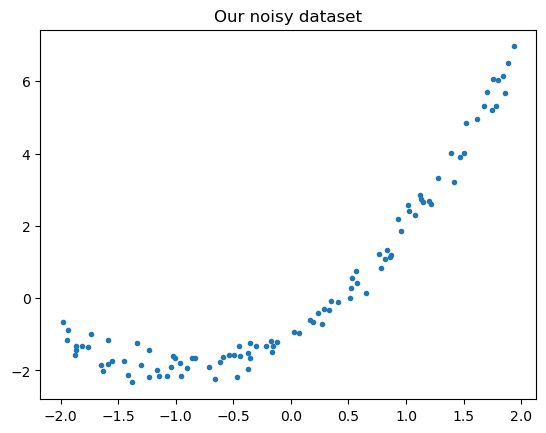

In [232]:
import matplotlib.pyplot as plt

plt.title('Our noisy dataset')
plt.plot(XX, YY, '.')
plt.show()

Now we are ready to estimate the values of our parameters, using only the observed samples, and the knowledge that the model we are seeking is a 2 degree polynomial.

First of all, we will define three variables for our weights that we will initialise to some value - you can try to change the initialisation value to check that it has no effect in the final result.

We will eventually want to calculate the derivatives of the error with respect to each of these weights, so that we can apply gradient descent. Therefore, these variables require gradient calculation as well.

In [233]:
# Create variables for our parameters (weights), and initialise them all to 1.0
w0 = Variable(0.0, requiresGrad = True)
w1 = Variable(0.0, requiresGrad = True)
w2 = Variable(0.0, requiresGrad = True)

Next, we do a bit of housekeeping. We define the learning rate that we will use (feel free to change it and see what happens), as well as an empty list in which we will be keeping track of the training loss as it evolves during our training.

*Note that we use "loss" and "cost" quite interchangably in these notebooks - the correct way to use it would be to call loss just the individual error for a single sample, and cost the aggregated error over the whole batch. In practice you will see these names used quite interchangably by different authors, and you should be able to tell what they refer to every time you see them.*

In [234]:
lr = 0.01 # Our learning rate
training_loss = []

Now we will define our typical training loop to implement gradient descent.

During each epoch we process the whole batch of data we have, and we will do 2000 epochs (feel free to change this and see what happens).

Within each epoch, we will take each sample in our dataset and do a forward pass - calculate the polynomial, using our current values for the weights. The result `out` is our estimated output for the sample. We will then compare it with the true value for the sample (the noisy value we have observed). Here we will use a Mean Square Error cost, so our loss is just the square distance between the estimated and the true (observed) value.

We will accumulate the loss for all samples into the `batch_loss` variable, and at the end of each epoch we will divide by the number of samples to get the average error.

This is the value that we will backpropagate. This will update the gradient information of all our variables that require gradients, all the way back to the three weights. These gradients are then used to update the weights using simple gradient descent.

In [235]:
import time

t = time.time() # Keep track of the time we started

for epoch in range(2000):

    #Zero gradients
    w0.zeroGrad()
    w1.zeroGrad()
    w2.zeroGrad()
    
    batch_loss = Variable(0.0)
    for x, y in zip(XX, YY):
        #Forward pass
        out = w0 + w1 * x + w2 * (x**2)
        
        # calculate loss for this training sample
        loss = (out - y)**2
        
        # accumulate losses
        batch_loss = batch_loss + loss
        

    # calculate cost (average of the individual losses)
    batch_loss = batch_loss/m
    training_loss.append(batch_loss.value) # keep track of how our training loss evolves
    
    #backpropagate
    batch_loss.backProp()

    #Update parameters
    w0.value = w0.value - lr * w0.grad
    w1.value = w1.value - lr * w1.grad
    w2.value = w2.value - lr * w2.grad    

    del batch_loss # this should free some resources

# Check how long it took
print("Training took (secs):", time.time() - t)

Training took (secs): 3.892324924468994


So, that took a while. Let's see what values we estimated.

Estimated weights: -0.9930404106691241 1.993734639761454 1.0076825647999852


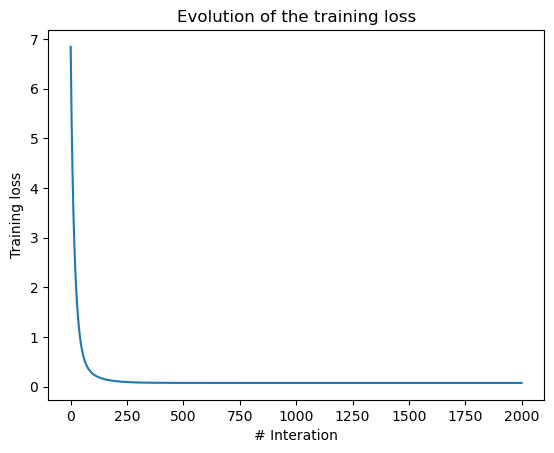

In [236]:
# Print our our results
print("Estimated weights:", w0.value, w1.value, w2.value)

#Make a plot of the evolution of the training loss
plt.title('Evolution of the training loss')
plt.xlabel("# Interation")
plt.ylabel("Training loss")
plt.plot(training_loss)
plt.show()

The estimated values are not very far off the real values we used in the beginning. This is good news. Let's also plot the estimated polynomial to double check.

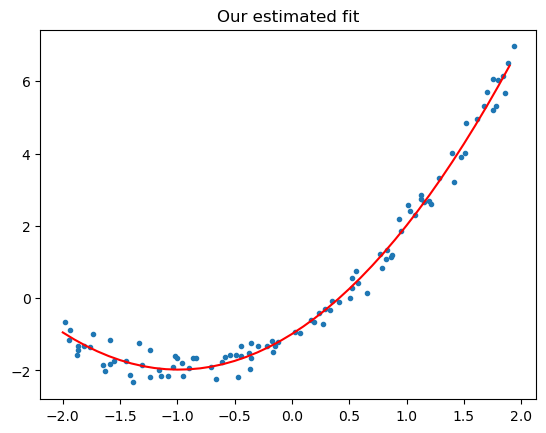

In [237]:
# Plot the result
plt.title('Our estimated fit')
plt.plot(XX, YY, '.')

x = np.arange(-2, 2, 0.1)
y = w0.value + w1.value * x + w2.value * x**2
plt.plot(x, y, 'r')

Note that the code above is VERY inefficient, but it should be readable.

<font color=blue>**Question:** Can you describe / draw the computation graph we have created here.</font>

<img src="WhatsApp Image 2023-02-27 at 19.05.48.jpeg" width="400" height="400">

<font color=blue>**Exercise:** Have a look at the slides of the course, and try to come up with a more efficient implementation. Measure the time it takes and confirm you are doing it better than what we achieved before.</font>

In [238]:
# Create variables for our parameters (weights), and initialise them all to 1.0
w0 = Variable(0.0, requiresGrad = True)
w1 = Variable(0.0, requiresGrad = True)
w2 = Variable(0.0, requiresGrad = True)

In [239]:
lr = 0.01 # Our learning rate
training_loss = []

In [240]:
#Splitting and randomizing mini batches
#indexes
indexes = np.arange(len(XX))
np.random.shuffle(indexes)

We'll do mini batches instead of full batch

In [241]:
NBATCHES = 10
import time

t = time.time() # Keep track of the time we started
    
for btch_idx in range(NBATCHES):
    #Zero gradients
    w0.zeroGrad()
    w1.zeroGrad()
    w2.zeroGrad()
    
    batch_X = XX[indexes[btch_idx*NBATCHES:(btch_idx+1)*(NBATCHES)]]
    batch_Y = YY[indexes[btch_idx*NBATCHES:(btch_idx+1)*(NBATCHES)]]
    batch_loss = Variable(0.0)
    for x, y in zip(batch_X,batch_Y):
        #Forward pass
        out = w0 + w1 * x + w2 * (x**2)
        
        # calculate loss for this training sample
        loss = (out - y)**2
        
        # accumulate losses
        batch_loss = batch_loss + loss

    # calculate cost (average of the individual losses)
    batch_loss = batch_loss/len(batch_X)
    training_loss.append(batch_loss.value) # keep track of how our training loss evolves

    #backpropagate
    batch_loss.backProp()

    #Update parameters
    w0.value = w0.value - lr * w0.grad
    w1.value = w1.value - lr * w1.grad
    w2.value = w2.value - lr * w2.grad    

    del batch_loss # this should free some resources

# Check how long it took
print("Training took (secs):", time.time() - t)

Training took (secs): 0.0013229846954345703


Estimated weights: 0.03055812750721249 0.47257565805913726 0.27774746892702906


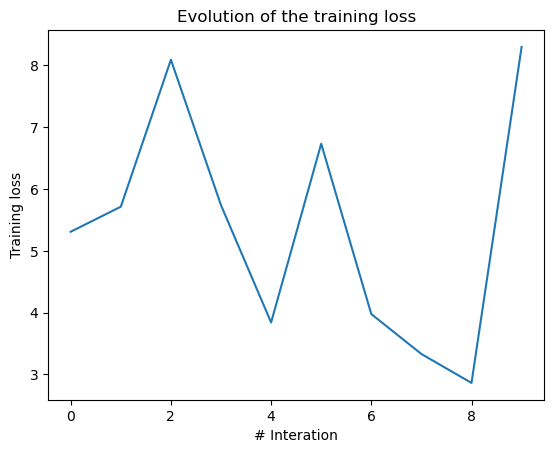

In [242]:
# Print our our results
print("Estimated weights:", w0.value, w1.value, w2.value)

#Make a plot of the evolution of the training loss
plt.title('Evolution of the training loss')
plt.xlabel("# Interation")
plt.ylabel("Training loss")
plt.plot(training_loss)
plt.show()

A lot faster but does not converge

## Classification

Now that we have seen how this works for regression, let's apply the same approach to a simple classification problem.

First, we will create some random data for two concentric classes. The decision boundary between the two classes will be a circle.

In [264]:
m_per_class = 50
m= 2 * m_per_class
w = [2.0, 1.0, 3.0] # corresponding to radius and center of a circular decision boundary

#Class 1 - random points inside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] * np.random.rand(m_per_class) #Radius in [0, w0]

XX1 = w[1] + radius * np.cos(angle)
XX2 = w[2] + radius * np.sin(angle)
labels = np.zeros(m_per_class)

#Class 2 - random points outside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] +  w[0] * np.random.rand(m_per_class) #Radius in [w0, 2 * w0]

XX1 = np.concatenate( (XX1, w[1] + radius * np.cos(angle)) )
XX2 = np.concatenate( (XX2, w[2] + radius * np.sin(angle)) )
labels = np.concatenate( (labels, np.ones(m_per_class)) )

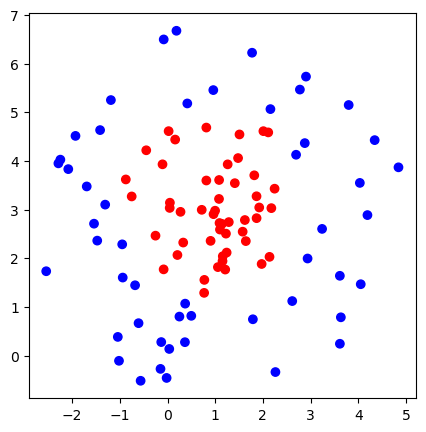

In [265]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.scatter(XX1, XX2, c = [('red' if cl == 0 else 'blue') for cl in labels])

Since we have our own AutoGrad framework, instead of handcrafting features we will try to solve this directly, assuming the equation of a circle with unknown centre and radius. Our AutoGrad framework will figure out the gradients for whatever equation we give it.

<font color=blue>**Exercise:** Adapt the solution for the regression problem we saw before to this scenario. This would imply changing the equation for the forward pass to the equation of a circle + sigmoid activation, and also changing the loss to a cross entropy one. Update the autograd framework as you see fit, in case you need to use operations you do not have.</font>

In [283]:
# Create variables for our parameters (weights), and initialise them all to 1.0
w0 = Variable(1.0, requiresGrad = True)
w1 = Variable(1.0, requiresGrad = True)
w2 = Variable(1.0, requiresGrad = True)
lr = 0.01 # Our learning rate
training_loss = []

import time
from tqdm import tqdm

t = time.time() # Keep track of the time we started

for epoch in tqdm(range(2000)):

    #Zero gradients
    w0.zeroGrad()
    w1.zeroGrad()
    w2.zeroGrad()
    
    batch_loss = Variable(0.0)
    for x1,x2, y in zip(XX1,XX2,labels):
        #Forward pass
        out = ((x1-w1)**2) + ((x2-w2)**2) - (w0**2)
        n_out = 1/(1+vExp(-out))
        
        # calculate loss for this training sample
        loss = (n_out - y)**2
        
        # accumulate losses
        batch_loss = batch_loss + loss
        

    # calculate cost (average of the individual losses)
    batch_loss = batch_loss/m
    training_loss.append(batch_loss.value) # keep track of how our training loss evolves
    
    #backpropagate
    batch_loss.backProp()

    #Update parameters
    w0.value = w0.value - lr * w0.grad
    w1.value = w1.value - lr * w1.grad
    w2.value = w2.value - lr * w2.grad    

    del batch_loss # this should free some resources

# Check how long it took
print("Training took (secs):", time.time() - t)
''

100%|██████████| 2000/2000 [00:19<00:00, 103.80it/s]

Training took (secs): 19.27034020423889


''

Estimated weights: 2.0120982527317945 0.9460590886679053 3.113834163119041


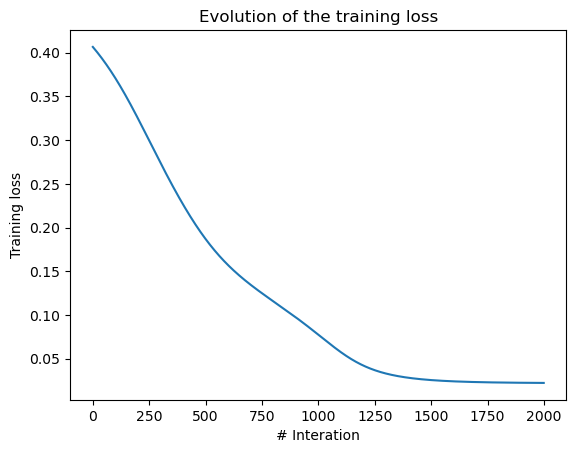

In [284]:
# Print our our results
print("Estimated weights:", w0.value, w1.value, w2.value)

#Make a plot of the evolution of the training loss
plt.title('Evolution of the training loss')
plt.xlabel("# Interation")
plt.ylabel("Training loss")
plt.plot(training_loss)
plt.show()

<font color=blue>**Exercise:** Once you find a solution, plot the resulting decision boundary (hint, have a look at the contour function of Matplotlib, and plot the contour of the loss function at the level 0.5)</font>

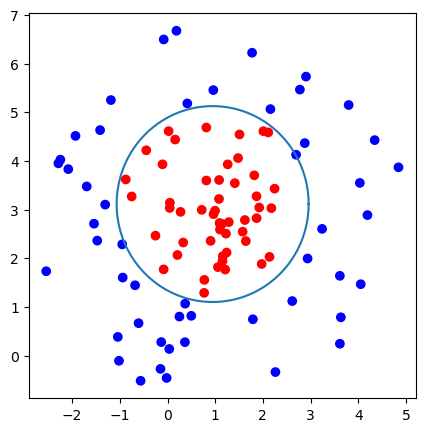

In [285]:
plt.figure(figsize = (5, 5))
plt.scatter(XX1, XX2, c = [('red' if cl == 0 else 'blue') for cl in labels])
#circle
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
x = w0.value * np.cos( angle ) + w1.value
y = w0.value * np.sin( angle ) + w2.value
plt.plot(x,y)
plt.show()

I noticed that having w0 start with value 0 it was getting stuck and not changing, loss wasing decreasing much. why?

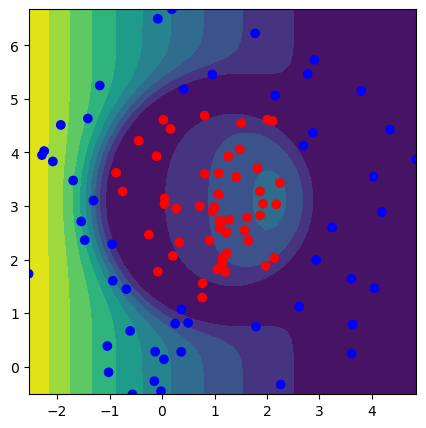

In [301]:
plt.figure(figsize = (5, 5))
#contour of the loss function
x_it = np.linspace(np.min(XX1),np.max(XX1)) 
y_it = np.linspace(np.min(XX2),np.max(XX2)) 
y = np.linspace(0,1)

[X,Y] = np.meshgrid(x_it,y_it)

threshold = 0.5
out = ((X-w1.value)**2) + ((Y-w2.value)**2) - (w0.value**2)
out_n = 1/(1+np.exp(-out))
loss = (out_n - y)**2
#plt.contourf(x_it,y_it,loss,levels=[0.1,0.5,0.9])
plt.contourf(x_it,y_it,loss,levels= 10)

#plot on top the data points
plt.scatter(XX1, XX2, c = [('red' if cl == 0 else 'blue') for cl in labels])

<font color=blue>**Exercise:** Evaluate your classifier and calculate the accuracy over the training dataset. If you feel adventurous, generate a separate test set with the same parameters and evaluate there.</font>

On train data:

In [317]:
pred = []
for x1,x2 in zip(XX1,XX2):
    out = ((x1-w1.value)**2) + ((x2-w2.value)**2) - (w0.value**2)
    out_n = 1/(1+np.exp(-out))
    if(out_n >= 0.5):
        pred.append(1.0)
    else:
        pred.append(0.0)

pred = np.array(pred)

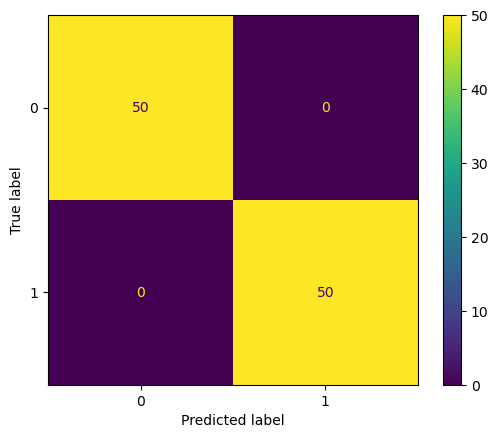

In [319]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =confusion_matrix(pred, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

On new test data:

In [322]:
m_per_class = 50
m= 2 * m_per_class
w = [2.0, 1.0, 3.0] # corresponding to radius and center of a circular decision boundary

#Class 1 - random points inside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] * np.random.rand(m_per_class) #Radius in [0, w0]

XX1_t = w[1] + radius * np.cos(angle)
XX2_t = w[2] + radius * np.sin(angle)
labels_t = np.zeros(m_per_class)

#Class 2 - random points outside the decision boundary
angle = 2.0 * np.pi * np.random.rand(m_per_class)
radius = w[0] +  w[0] * np.random.rand(m_per_class) #Radius in [w0, 2 * w0]

XX1_t = np.concatenate( (XX1_t, w[1] + radius * np.cos(angle)) )
XX2_t = np.concatenate( (XX2_t, w[2] + radius * np.sin(angle)) )
labels_t = np.concatenate( (labels_t, np.ones(m_per_class)) )

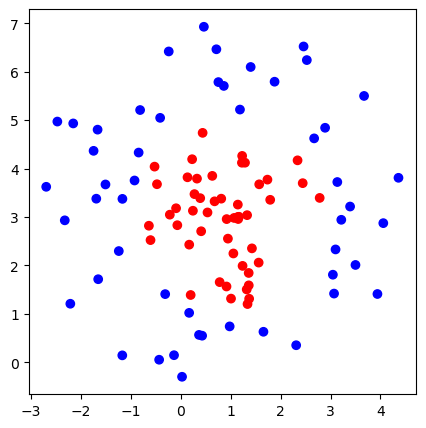

In [323]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.scatter(XX1_t, XX2_t, c = [('red' if cl == 0 else 'blue') for cl in labels])

In [324]:
pred = []
for x1,x2 in zip(XX1_t,XX2_t):
    out = ((x1-w1.value)**2) + ((x2-w2.value)**2) - (w0.value**2)
    out_n = 1/(1+np.exp(-out))
    if(out_n >= 0.5):
        pred.append(1.0)
    else:
        pred.append(0.0)

pred = np.array(pred)

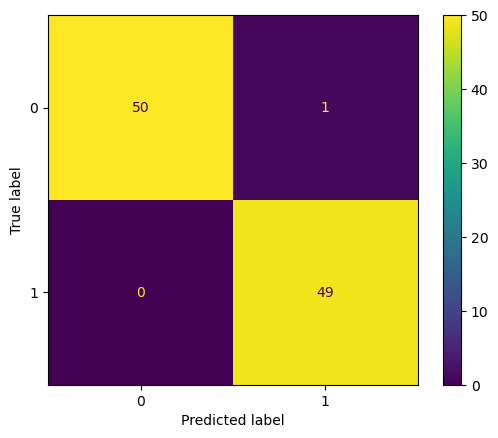

In [325]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =confusion_matrix(pred, labels_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()